In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
import numpy as np
import pandas as pd

from copy import deepcopy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### predefined functions and utilities

In [2]:
def build_ion_dictionary(path):
    """
    build up a dictionary for ion and their fingerprint
    :param path:string
    :return:dict()
    """
    iondict = dict()
    raw_dict = pd.read_csv(path)

    # build up the dictionary
    for value in raw_dict.values:
        try:
            mol = Chem.MolFromSmiles(value[2])
            mol = Chem.AddHs(mol)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        except:
            print("fingerprint transformation failed")

        if value[0] not in iondict:
            iondict[value[0]] = (fp,value[2])

    return iondict

In [3]:
def feature_embedding(path,ion_dict):
    """
    embed all of the data into fingerprint+T+P
    :param path:string
    :param ion_dict:dict
    :return:tuple
    """
    # value to return
    data_vector = []
    smiles_for_scaffold_split = []
    label = []
    wrapup = []

    raw_data = pd.read_csv(path)
    # visualize
    print(raw_data.columns)

    for data in raw_data.values:
        if data[1] not in ion_dict or data[2] not in ion_dict:
            continue
        # for scaffold spilt
        smiles_for_scaffold_split.append(ion_dict[data[1]][1])

        # embedding
        vector = list(ion_dict[data[1]][0]) + list(ion_dict[data[2]][0]) + [data[4]] + [data[5]]
        data_vector.append(vector)

        # label
        label.append(data[3])

    wrapup.append(np.array(data_vector))
    wrapup.append(np.asarray(smiles_for_scaffold_split))
    wrapup.append(np.array(label))

    return tuple(wrapup)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [4]:
def feature_origin(path,ion_dict):
    """
    return the original version of embedding using functional group method
    :param path:string
    :return:tuple
    """
    embeds = []
    smiles_for_scaffold_split = []
    wrapup = []
    label = []

    datas = pd.read_csv(path)

    for data in datas.values:
        if data[1] not in ion_dict or data[2] not in ion_dict:
            continue
        # for scaffold spilt
        smiles_for_scaffold_split.append(ion_dict[data[1]][1])

        # embed
        embed = data[4:-1] 
        embeds.append(embed)

        # label
        label.append(data[3])

    wrapup.append(np.array(embeds))
    wrapup.append(np.asarray(smiles_for_scaffold_split))
    wrapup.append(np.array(label))

    return tuple(wrapup)

In [5]:
def _generate_scaffold(smiles, include_chirality=False):
    """
    generate Murcko scaffold for input smiles
    :param smiles: string
    :param include_chirality:Boolean
    :return: string
    """
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

In [6]:
def generate_scaffolds(smiles_data, log_every_n=1000):
    """
    categorize the molecule into different group accord to there scaffold
    :param smiles_data: list of string
    :param log_every_n: default
    :return: list(list())
    """
    scaffolds = {}  # initialized as a dictionary
    data_len = len(smiles_data)

    print("About to generate scaffolds")
    for ind, smiles in enumerate(smiles_data):
        # just to show the process
        if ind % log_every_n == 0:
            print("Generating scaffold %d/%d" % (ind, data_len))  # way to print number
        # begin from here
        scaffold = _generate_scaffold(smiles)

        # categorized molecule depend on its Murcko scaffold
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [ind]
        else:
            scaffolds[scaffold].append(ind)
            
    # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}  # sort index in each category
    scaffold_sets = [
        scaffold_set for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True) 
    ]
    return scaffold_sets

In [7]:
def scaffold_split(smiles_data, valid_size, test_size, seed=None, log_every_n=1000):
    """
    conduct scaffold splitting
    :param smiles_data:
    :param valid_size:
    :param test_size:
    :param seed:
    :param log_every_n:
    :return: list of index,list of index,list of index
    """


    train_size = 1.0 - valid_size - test_size
    scaffold_sets = generate_scaffolds(smiles_data)  
    train_cutoff = train_size * len(smiles_data)
    valid_cutoff = (train_size + valid_size) * len(smiles_data)
    train_inds: List[int] = []
    valid_inds: List[int] = []
    test_inds: List[int] = []

    print("About to sort in scaffold sets")
    for scaffold_set in scaffold_sets:
        if len(train_inds) + len(scaffold_set) > train_cutoff:
            if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
                test_inds += scaffold_set
            else:
                valid_inds += scaffold_set
        else:
            train_inds += scaffold_set
    return train_inds, valid_inds, test_inds

In [8]:
def random_split( dataset_size , valid_size, test_size ):
    """
    conduct random split on the data set
    :param dataset_size: int
    :param valid_size: float
    :param test_size: float
    :return:list, list, list
    """
    total_ins = list(range(0,dataset_size))
    random.shuffle(total_ins)

    train_cutoff = int(dataset_size*(1-valid_size-test_size))
    test_cutoff = int(dataset_size*test_size)

    train_ins = total_ins[0 : train_cutoff]
    test_ins = total_ins[train_cutoff : train_cutoff + test_cutoff]
    valid_ins = total_ins[train_cutoff + test_cutoff : ]

    return train_ins,valid_ins,test_ins

In [10]:
# for fingerprint
class NN(nn.Module):
    """
    define the NN model
    """
    def __init__(self,n_features):
        super(NN, self).__init__()
        self.layer_1 = nn.Linear( in_features = n_features, out_features = 256 )
        self.layer_2 = nn.Linear( in_features = 256, out_features = 128 )
        self.layer_3 = nn.Linear( in_features = 128, out_features = 64 )
        self.layer_4 = nn.Linear( in_features = 64, out_features = 1 )

    def forward(self, data):
        data = data.to(torch.float32)
        data = F.relu(self.layer_1(data))
        data = F.relu(self.layer_2(data))
        data = F.relu(self.layer_3(data))
        data = self.layer_4(data)
        
        return data

In [11]:
# training
def train(epoch):
    """
    trainning part
    """
    predictions = []
    labels = []
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output.squeeze(), target.float())

        loss.backward()
        optimizer.step()
        
        # gather the result for ploting
        predictions.extend(output.detach().numpy())
        labels.extend(target.flatten().numpy())
    return predictions, labels

In [12]:
# test
def test(test_loader):
    """
    testing part
    """
    predictions = []
    labels = []
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        i = 0
        for data, target in test_loader:
            i += 1
            output = model(data)
          
            # sum up batch loss
            test_loss += F.mse_loss(output.squeeze(), target.float()).item()
      
            # gather the result for ploting
            predictions.extend(output.detach().numpy())
            labels.extend(target.flatten().numpy())
            
        test_loss /= i
        print('\nTest set: Average loss: {:.4f}'.format(
            test_loss))
        
        predictions = np.array(predictions)
        labels = np.array(labels)
        mae = mean_absolute_error(labels, predictions)
        r2 = r2_score(labels, predictions)
        print('test loss:', test_loss, 'MAE:', mae, 'R2', r2)
        return test_loss, mae, r2, predictions, labels

In [32]:
def plot(labels, predictions,tl,tp,name):
    xymin = min(np.min(labels), np.max(predictions))
    xymax = max(np.max(labels), np.max(predictions))

    fig, ax = plt.subplots(figsize=(8,8))
    print(type(ax))
    ax.scatter(labels, predictions, s=25, edgecolors='None', linewidths=0.4,c = 'orange',label = 'train data')
    ax.scatter(tl, tp, s=25, edgecolors='None', linewidths=0.4,c = 'yellow',label = 'test data')
    x = np.linspace(xymin, xymax)
    y = np.linspace(xymin, xymax)
    ax.plot(x, y, linestyle='dashed', c='black')
    
    ax.set_xlabel('Label', fontsize=25)
    ax.set_ylabel('Prediction', fontsize=25)
    ax.tick_params(direction='in', width=2,labelsize = 20)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)
    ax.legend(fontsize = 20)
    plt.savefig(name)

### trainning model based on functional group feature extraction

In [14]:
# experiment for functional group method
# build up the dictionary for ion fingerprint
ion_dict = deepcopy(build_ion_dictionary(path = "data/smiles.csv"))

# embedding the data with fingerprint and Temperature,Pressure
wrapdata = deepcopy(feature_origin(path = "data/whole.csv",ion_dict = ion_dict))# extract feature with functional group method
data = wrapdata[0].astype(np.float32)
smiles = wrapdata[1]
labels = wrapdata[2]

# verify the embedded data
print("verification")
print(type(data),len(data))
print(type(smiles),len(smiles))
print(type(labels), len(labels))

# perform scaffold splitting on the dataset
train_idx, valid_idx, test_idx = random_split(len(smiles), 0.0, 0.2)
train_set, train_labels = data[train_idx], labels[train_idx]
valid_set, valid_labels = data[valid_idx], labels[valid_idx]# remember here
test_set, test_labels = data[test_idx], labels[test_idx]

# prepare data for the loader
train_da = list(zip(train_set,train_labels))
valid_da = list(zip(valid_set,valid_labels))
test_da = list(zip(test_set,test_labels))

# loading data
train_loader = DataLoader(train_da, batch_size=64, shuffle=True)
test_loader = DataLoader(test_da, batch_size=64, shuffle=False)

verification
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116


In [15]:
# model train for functional group embedding
n_features = len(data[0])
Epoch = 300
warmup = 40
model = NN(n_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=Epoch-9)
loss = float('inf')

GC_loss = []

for epoch in range(Epoch):
    print("epoch",epoch)
    train_predictions, train_labels = train(epoch)
    test_loss, test_mae, test_r2, test_predictions, test_labels = test(test_loader)
    GC_loss.append(test_loss)
    if epoch >= warmup:
        scheduler.step()

    if test_loss <= loss:
        loss = test_loss
        torch.save(model.state_dict(), 'best_model_para.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_para.pth')

epoch 0

Test set: Average loss: 0.0142
test loss: 0.01424034932279028 MAE: 0.08998007685561102 R2 0.7441909665098319
epoch 1

Test set: Average loss: 0.0185
test loss: 0.01853540915180929 MAE: 0.10581599066440925 R2 0.6663457044590795
epoch 2

Test set: Average loss: 0.0124
test loss: 0.012436291435733438 MAE: 0.0812437787838015 R2 0.7765066964018261
epoch 3

Test set: Average loss: 0.0140
test loss: 0.014035920205060393 MAE: 0.08510813667942928 R2 0.7478214876876026
epoch 4

Test set: Average loss: 0.0124
test loss: 0.012405434710672125 MAE: 0.08620053783793538 R2 0.7764521426218318
epoch 5

Test set: Average loss: 0.0092
test loss: 0.009225667963619344 MAE: 0.07182566696403488 R2 0.8338505800032661
epoch 6

Test set: Average loss: 0.0166
test loss: 0.016619376663584262 MAE: 0.10602938013059761 R2 0.7010192529057444
epoch 7

Test set: Average loss: 0.0082
test loss: 0.008154918818036094 MAE: 0.06443893780586558 R2 0.8532172441124203
epoch 8

Test set: Average loss: 0.0075
test loss: 

In [16]:
# model evaluation for functional group embedding
model = NN(n_features)
state_dict_mod = torch.load('best_model_para.pth')
model.load_state_dict(state_dict_mod)

optimizer = optim.Adam(model.parameters(), lr=0.001)
state_dict_opt = torch.load('best_optimizer_para.pth')
optimizer.load_state_dict(state_dict_opt)

train_loss, train_mae, train_r2, train_predictions, train_labels = test(train_loader)
test_loss, test_mae, test_r2, test_predictions, test_labels = test(test_loader)


Test set: Average loss: 0.0006
test loss: 0.0006400040508060914 MAE: 0.016065828603275187 R2 0.9885862427286239

Test set: Average loss: 0.0008
test loss: 0.0007736734632999287 MAE: 0.017995333081208705 R2 0.9860143101555422


<class 'matplotlib.axes._subplots.AxesSubplot'>


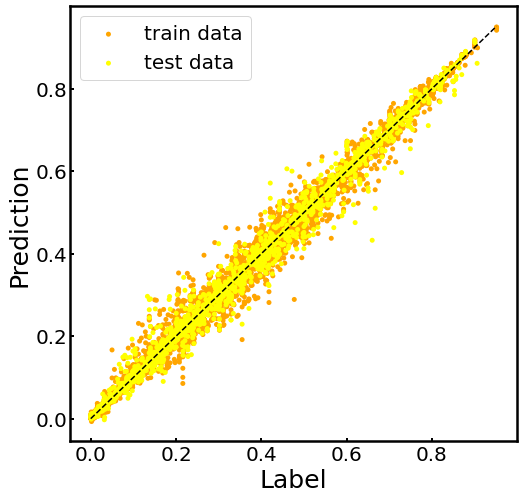

In [34]:
plot(train_labels,train_predictions,test_labels,test_predictions,'MLP_GC')

In [18]:
print('MAE',test_mae,"R2",test_r2)

MAE 0.017995333081208705 R2 0.9860143101555422


### trainning model based on fingerprint feature extraction

In [19]:
# build up the dictionary for ion fingerprint
ion_dict = deepcopy(build_ion_dictionary(path = "data/smiles.csv"))

# embedding the data with fingerprint and Temperature,Pressure
wrapdata = deepcopy(feature_embedding(path = "data/whole.csv",ion_dict = ion_dict))
# wrapdata = deepcopy(feature_origin(path = "data/whole.csv",ion_dict = ion_dict))
data = wrapdata[0].astype(np.float32)
smiles = wrapdata[1]
labels = wrapdata[2]

# verify the embedded data
print("verification")
print(type(data),len(data))
print(type(smiles),len(smiles))
print(type(labels), len(labels))

# perform scaffold splitting on the dataset
# train_idx, valid_idx, test_idx = scaffold_split(smiles, 0.1, 0.1)
train_idx, valid_idx, test_idx = random_split(len(smiles), 0.0, 0.2)
train_set, train_labels = data[train_idx], labels[train_idx]
valid_set, valid_labels = data[valid_idx], labels[valid_idx]# remember here
test_set, test_labels = data[test_idx], labels[test_idx]

# prepare data for the loader
train_da = list(zip(train_set,train_labels))
valid_da = list(zip(valid_set,valid_labels))
test_da = list(zip(test_set,test_labels))

# loading data
train_loader = DataLoader(train_da, batch_size=64, shuffle=True)
test_loader = DataLoader(test_da, batch_size=64, shuffle=False)

Index(['IL', 'cation', 'anion', 'x_CO2', 'T (K)', 'P (bar)', '[CH3]', '[CH2]',
       '[CH]', '[OCH2]', '[OCH3]', '[CF2]', '[CF3]', '[OH]', 'CH=CH', 'CH=CH2',
       '[Im13]', '[MIm]', '[MMIM]', '[Py]', '[MPy]', '[MPyrro]', '[MPip]',
       '[NH3]', '[NH2]', '[NH]', '[N]', '[P]', '[S]', '[BF4]', '[Cl]', '[DCA]',
       '[NO3]', '[PF6]', '[SCN]', '[TCB]', '[C(CN)3]', '[HSO4]', '[FSA]',
       '[Tf2N]', '[BETA]', '[FOR]', '[TFA]', '[C3F7CO2]', '[MeSO4]', '[EtSO4]',
       '[MDEGSO4]', '[MeSO3]', '[TfO]', '[NfO]', '[TDfO]', '[TOS]',
       '[C12PhSO3]', '[DMPO4]', '[DEPO4]', '[DBPO4]', '[methide]',
       'Unnamed: 57'],
      dtype='object')
verification
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116


In [20]:
n_features = len(data[0])

warmup = 40
model = NN(n_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=Epoch-9)
loss = float('inf')
FP_loss = []
for epoch in range(Epoch):
    print("epoch",epoch)
    train_predictions, train_labels = train(epoch)
    test_loss, test_mae, test_r2, test_predictions, test_labels = test(test_loader)
    FP_loss.append(test_loss)
    if epoch >= warmup:
        scheduler.step()
    # print(type(test_loss))
    if test_loss <= loss:
        loss = test_loss
        torch.save(model.state_dict(), 'best_model_para.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_para.pth')

epoch 0

Test set: Average loss: 0.0083
test loss: 0.008309515062137507 MAE: 0.06944206504884566 R2 0.8529733422757693
epoch 1

Test set: Average loss: 0.0036
test loss: 0.003587678715121001 MAE: 0.0453106220329026 R2 0.9365231511735861
epoch 2

Test set: Average loss: 0.0026
test loss: 0.0025779174866329413 MAE: 0.037475124323407015 R2 0.9545384645460093
epoch 3

Test set: Average loss: 0.0015
test loss: 0.0015007628262537764 MAE: 0.027045494320595907 R2 0.9735215863100586
epoch 4

Test set: Average loss: 0.0026
test loss: 0.002635365461173933 MAE: 0.04004564297245932 R2 0.9531444510603292
epoch 5

Test set: Average loss: 0.0015
test loss: 0.0015070514746184926 MAE: 0.028034619617438545 R2 0.9732529546692453
epoch 6

Test set: Average loss: 0.0018
test loss: 0.001798617475287756 MAE: 0.03300741250311484 R2 0.9682321081014857
epoch 7

Test set: Average loss: 0.0017
test loss: 0.001727867012959905 MAE: 0.03092952456746579 R2 0.9691600122913168
epoch 8

Test set: Average loss: 0.0013
tes

In [21]:
model = NN(n_features)
state_dict_mod = torch.load('best_model_para.pth')
model.load_state_dict(state_dict_mod)

optimizer = optim.Adam(model.parameters(), lr=0.001)
state_dict_opt = torch.load('best_optimizer_para.pth')
optimizer.load_state_dict(state_dict_opt)


train_loss, train_mae, train_r2, train_predictions, train_labels = test(train_loader)
test_loss, test_mae, test_r2, test_predictions, test_labels = test(test_loader)


Test set: Average loss: 0.0004
test loss: 0.000400110470327204 MAE: 0.011566304130474696 R2 0.9927975992986813

Test set: Average loss: 0.0007
test loss: 0.0006877036839796347 MAE: 0.015267928485818868 R2 0.987735257150467


<class 'matplotlib.axes._subplots.AxesSubplot'>


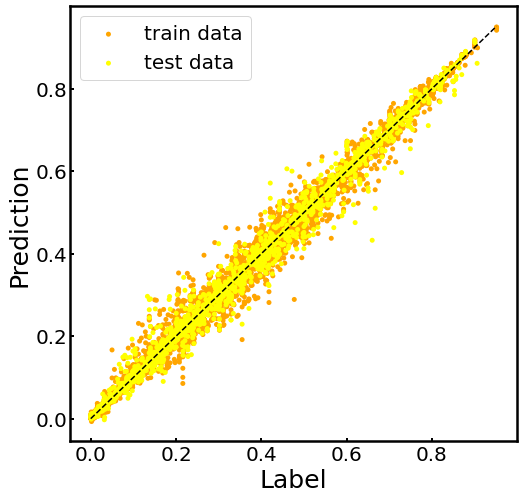

In [33]:
plot(train_labels,train_predictions,test_labels,test_predictions,'MLP_FP')

In [23]:
print('MAE',test_mae,"R2",test_r2)

MAE 0.015267928485818868 R2 0.987735257150467


### Compare the loss change during training between two method(functional group and fingerprint)

/tmp/ipykernel_242/3533095886.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(GC_loss,label = 'Group Contribution Method',linewidth=2,C = 'c')
/tmp/ipykernel_242/3533095886.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(FP_loss,label = 'Fingerprint Method',linewidth=2,C = 'b')


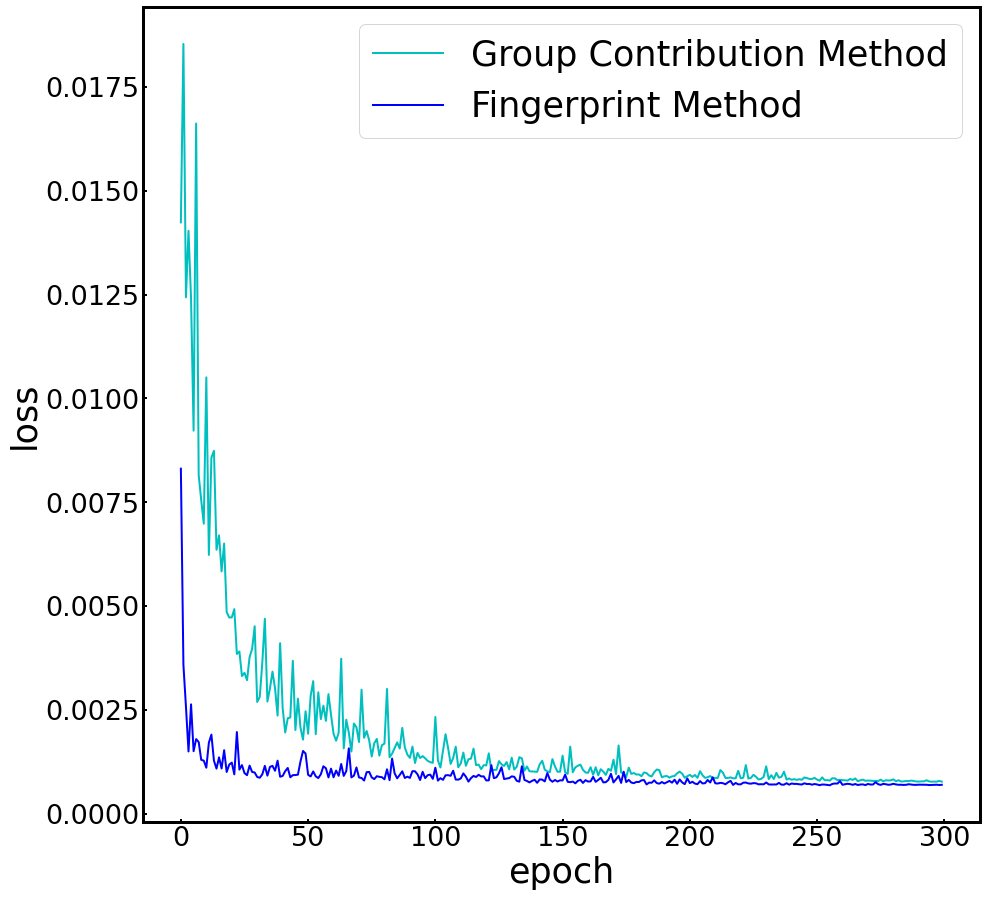

In [45]:
fig = plt.figure(figsize = (15,15))
x = np.arange(Epoch)
plt.plot(GC_loss,label = 'Group Contribution Method',linewidth=2,C = 'c')
plt.plot(FP_loss,label = 'Fingerprint Method',linewidth=2,C = 'b')

plt.xlabel('epoch',fontsize = 35)
plt.ylabel('loss',fontsize = 35)
plt.tick_params(direction='in', width=2,labelsize = 27)
plt.legend(fontsize = 35)
ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.savefig('MLP train process compare')